# Correlation plots

In [94]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None:
        print(" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Netherlands
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


In [4]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in tqdm(enumerate(countries)):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

0it [00:00, ?it/s]

In [5]:
data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))
country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]

In [6]:
# Compute interesting values as fraction and as incidence
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country","gender"])
    primary_frac.append(temp.to_numpy()[:,0])


primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])


primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_secondary[i]
    primary_and_subsequent_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)
    


In [7]:
from sklearn.linear_model import LinearRegression

def plot_corr(ax,x,y,ci_axis_x=None,ci_axis_y=None, linearRegression=False, pvalue=True,inverse_pvalue=False,):
    """ Creates correlation plot for two variables x and y

        Parameters
        ----------
        ax : matplotlib.axes.Axes
            Axes object to plot on
        x : np.ndarray
            Array of x values
        y : np.ndarray
            Array of y values
        ci_axis : int
    """
    # Compute mean and ci
    
    # compute ci
    if ci_axis_y is not None:
        y_mean = [np.mean(yi,axis=ci_axis_y) for yi in y]
        y_p025 = [np.percentile(yi, 2.5,axis=ci_axis_y) for yi in y]
        y_p975 = [np.percentile(yi,97.5,axis=ci_axis_y) for yi in y]
    else:
        y_mean = y
        y_p025 = None
        y_p975 = None
    
    if ci_axis_x is not None:
        x_mean = [np.mean(xi,axis=ci_axis_x) for xi in x]
        x_p025 = [np.percentile(xi, 2.5,axis=ci_axis_x) for xi in x]
        x_p975 = [np.percentile(xi,97.5,axis=ci_axis_x) for xi in x]
    else:
        x_mean = x
        x_p025 = None
        x_p975 = None


    if y_p025 is not None and y_p975 is not None:
        # Plot error bars
        lines = ax.vlines(
            x=x_mean,
            ymin=y_p025,
            ymax=y_p975,
            lw=2,
            zorder=9,
            color="#060434",
        )
        lines.set_capstyle("round")

    if x_p025 is not None and x_p975 is not None:
        # Plot error bars
        lines = ax.hlines(
            y=y_mean,
            xmin=x_p025,
            xmax=x_p975,
            lw=2,
            zorder=9,
            color="#060434",
        )
        lines.set_capstyle("round")

    ax.scatter(
        x=x_mean,
        y=y_mean,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )

    if linearRegression:
        models = []
        n_bootstrap = 3000
        for i in range(n_bootstrap):
            samples_x = []
            samples_y = []
            for country in range(len(x_mean)):
                # Draw random sample
                if ci_axis_x is not None:
                    x_sample = np.random.choice(x[country], size=1, replace=True)[0]
                else:
                    x_sample = x[country]
                if ci_axis_y is not None:
                    y_sample = np.random.choice(y[country], size=1, replace=True)[0]
                else:
                    y_sample = y[country]
                samples_x.append(x_sample)
                samples_y.append(y_sample)
            samples_x = np.array(samples_x)
            samples_y = np.array(samples_y)
            
            # Fit model
            models.append(LinearRegression().fit(samples_x.reshape(-1, 1), samples_y.reshape(-1, 1)))

        
        # Plot models
        x_plot = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
        y_plot = []
        for model in models:
            y_plot.append(model.predict(x_plot.reshape(-1,1)))
        y_plot = np.array(y_plot)[:,:,0]
        # Compute mean and ci
        mean_mod = y_plot.mean(axis=0)
        p025_mod = np.percentile(y_plot, 2.5,axis=0)
        p975_mod = np.percentile(y_plot,97.5,axis=0)

        ax.plot(x_plot,mean_mod,color="#009988",lw=1)
        ax.fill_between(x_plot,p025_mod,p975_mod,color="#009988",alpha=0.2)

        if pvalue:

            # Calculate p-value
            bigger = []
            for model in models:
                if inverse_pvalue:
                    bigger.append(model.coef_[0] < 0)
                else:
                    bigger.append(model.coef_[0] > 0)
            p_val = np.sum(bigger) / n_bootstrap
            
            # Plot
            ax.text(
                x=0.005,
                y=.01,
                s=f"$P(a>0)= {p_val:.3f}$",
                fontsize=8,
                transform=ax.transAxes,
            )


## Correlation between NPIs stringency pre EURO2020 and effect size
Creates a correlation plot between the non-pharmacutical interventions (NPIs) stringency as tracked by the Oxford Stringency Index and the primary and secondary soccer related effect.

In [8]:
# Load stringency index
from covid19_inference import data_retrieval as cov19dat

stringency = cov19dat.OxCGRT(True)

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded OxCGRT.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/OxCGRT.csv.gz successful.


In [9]:
import datetime
meanStringencyPreEuro2020 = []
stdStringencyPreEuro2020 = []

# Begin and end dates for EURO2020
begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

for i, country in enumerate(countries):
    if country == "Slovakia":
        country = "Slovak Republic"
    if country == "Czechia":
        country = "Czech Republic"
    if country in ["England","Scotland"]:
        SindexCountry = stringency.data[stringency.data["RegionName"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]
    else:
        SindexCountry = stringency.data[stringency.data["country"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]

    meanStringencyPreEuro2020.append(SindexCountry.mean())
    stdStringencyPreEuro2020.append(SindexCountry.std())

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


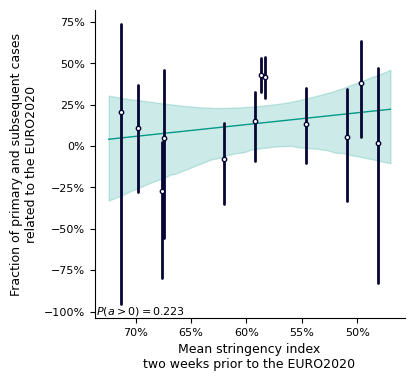

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

plot_corr(ax,meanStringencyPreEuro2020,primary_and_subsequent_frac,ci_axis_y=0,linearRegression=True)
ax.set_ylabel("Fraction of primary and subsequent cases\nrelated to the EURO2020")
ax.set_xlabel("Mean stringency index\ntwo weeks prior to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(100,0))
ax.set_xlim(ax.get_xlim()[1],ax.get_xlim()[0])
plt.show()



fig.savefig(f"../figures/correlation_NPIstringency.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_NPIstringency.png", **save_kwargs)
plt.close(fig=fig)

## Correlation between Mobility during EURO2020 and effect size

Creates a correlation plot between google mobility index and the primary and secondary soccer related effect.

In [11]:
mobility = cov19dat.GOOGLE(True)
df = mobility.data
df = df.reset_index()

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded Google.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/Google.csv.gz successful.


In [12]:
city2country = {
    'Aberdeen City': 'Scotland',
    'Aberdeenshire': 'Scotland',
    'Angus Council': 'Scotland',
    'Antrim and Newtownabbey': 'Northern Ireland',
    'Ards and North Down': 'Northern Ireland',
    'Argyll and Bute Council': 'Scotland',
    'Armagh City, Banbridge and Craigavon': 'Northern Ireland',
    'Bath and North East Somerset': 'England',
    'Bedford': 'England',
    'Belfast': 'Northern Ireland',
    'Blackburn with Darwen': 'England',
    'Blackpool': 'England',
    'Blaenau Gwent': 'Wales',
    'Borough of Halton': 'England',
    'Bracknell Forest': 'England',
    'Bridgend County Borough': 'Wales',
    'Brighton and Hove': 'England',
    'Bristol City': 'England',
    'Buckinghamshire': 'England', 
    'Caerphilly County Borough': 'Wales',
    'Cambridgeshire': 'England', 
    'Cardiff': 'Wales',
    'Carmarthenshire': 'Wales', 
    'Causeway Coast and Glens': 'England',
    'Central Bedfordshire': 'England',
    'Ceredigion': 'Wales',
    'Cheshire East': 'England',
    'Cheshire West and Chester': 'England',
    'Clackmannanshire': 'Scotland',
    'Conwy Principal Area': 'Wales',
    'Cornwall': 'England',
    'County Durham': 'England',
    'Cumbria': 'England',
    'Darlington': 'England',
    'Denbighshire': 'Wales',
    'Derby': 'England',
    'Derbyshire': 'England',
    'Derry and Strabane': 'Northern Ireland',
    'Devon': 'England',
    'Dorset': 'England',
    'Dumfries and Galloway': 'Scotland',
    'Dundee City Council': 'Scotland',
    'East Ayrshire Council': 'Scotland',
    'East Dunbartonshire Council': 'Scotland',
    'East Lothian Council': 'Scotland',
    'East Renfrewshire Council': 'Scotland',
    'East Riding of Yorkshire': 'England',
    'East Sussex': 'England',
    'Edinburgh': 'Scotland',
    'Essex': 'England',
    'Falkirk': 'Scotland',
    'Fermanagh and Omagh': 'Northern Ireland',
    'Fife': 'Scotland',
    'Flintshire': 'Wales',
    'Glasgow City': 'Scotland',
    'Gloucestershire': 'England',
    'Greater London': 'England',
    'Greater Manchester': 'England',
    'Gwynedd': 'Wales',
    'Hampshire': 'England',
    'Hartlepool': 'England',
    'Herefordshire': 'England',
    'Hertfordshire': 'England',
    'Highland Council': 'Scotland',
    'Inverclyde': 'Scotland',
    'Isle of Anglesey': 'Wales',
    'Isle of Wight': 'England',
    'Kent': 'England',
    'Kingston upon Hull': 'England',
    'Lancashire': 'England',
    'Leicester': 'England',
    'Leicestershire': 'England',
    'Lincolnshire': 'England',
    'Lisburn and Castlereagh': 'Northern Ireland',
    'Luton': 'England',
    'Medway': 'England',
    'Merseyside': 'England',
    'Merthyr Tydfil County Borough': 'Wales',
    'Mid and East Antrim': 'Northern Ireland',
    'Mid Ulster': 'Northern Ireland',
    'Middlesbrough': 'England',
    'Midlothian': 'Scotland',
    'Milton Keynes':  'England',
    'Monmouthshire': 'Wales',
    'Moray': 'Scotland',
    'Na h-Eileanan an Iar': 'Scotland',
    'Neath Port Talbot Principle Area': 'Wales',
    'Newport': 'Wales',
    'Newry, Mourne and Down': 'Northern Ireland',
    'Norfolk': 'England',
    'North Ayrshire Council': 'Scotland',
    'North East Lincolnshire': 'England',
    'North Lanarkshire': 'Scotland',
    'North Lincolnshire': 'England',
    'North Somerset': 'England',
    'North Yorkshire': 'England',
    'Northamptonshire': 'England',
    'Northumberland': 'England',
    'Nottingham': 'England',
    'Nottinghamshire': 'England',
    'Orkney': 'Scotland',
    'Oxfordshire': 'England',
    'Pembrokeshire': 'Wales',   
    'Perth and Kinross': 'Scotland',
    'Peterborough': 'England',
    'Plymouth': 'England',
    'Portsmouth': 'England',
    'Powys': 'Wales',
    'Reading': 'England',
    'Redcar and Cleveland': 'England',
    'Renfrewshire': 'Scotland',
    'Rhondda Cynon Taff': 'Wales',
    'Rutland': 'England',
    'Scottish Borders': 'Scotland',
    'Shetland Islands': 'Scotland',
    'Shropshire': 'England',
    'Slough': 'England',
    'Somerset': 'England',
    'South Ayrshire Council': 'Scotland',
    'South Gloucestershire': 'England',
    'South Lanarkshire': 'Scotland',
    'South Yorkshire': 'England',
    'Southampton': 'England',
    'Southend-on-Sea': 'England',
    'Staffordshire': 'England',
    'Stirling': 'Scotland',
    'Stockton-on-Tees': 'England',
    'Stoke-on-Trent': 'England',
    'Suffolk': 'England',
    'Surrey': 'England',
    'Swansea': 'Wales',
    'Swindon': 'England',
    'Thurrock': 'England',
    'Torbay': 'England',
    'Torfaen Principal Area': 'Wales',
    'Tyne and Wear': 'England',
    'Vale of Glamorgan': 'Wales',
    'Warrington': 'England',
    'Warwickshire': 'England',
    'West Berkshire': 'England',
    'West Dunbartonshire Council': 'Scotland',
    'West Lothian': 'Scotland',
    'West Midlands': 'England',
    'West Sussex': 'England',
    'West Yorkshire': 'England',
    'Wiltshire': 'England',
    'Windsor and Maidenhead': 'England',
    'Wokingham': 'England',
    'Worcestershire': 'England',
    'Wrexham Principal Area': 'Wales',
    'York': 'England'
}


def apply_city_to_country(row):
    if row["state"] in city2country:
        row["country"] = city2country[row["state"]]
    return row

df[df["country"]=="United Kingdom"] = df[df["country"]=="United Kingdom"].apply(apply_city_to_country, axis=1)

In [13]:

measures = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

measure2title = {
    'retail_and_recreation_percent_change_from_baseline': 'Retail and recreation',
    'grocery_and_pharmacy_percent_change_from_baseline': 'Grocery and pharmacy',
    'parks_percent_change_from_baseline': 'Parks',
    'transit_stations_percent_change_from_baseline': 'Transit stations',
    'workplaces_percent_change_from_baseline': 'Workplaces',
    'residential_percent_change_from_baseline': 'Residential'
}

meanMobilityEuro2020 = {}
for measure in measures:
    meanMobilityEuro2020[measure] = []

for i, country in enumerate(countries):
    # Mean over all Scotland and England entries
    if country in ["Scotland","England"]:
        temp = df[df["country"]==country].groupby("date").mean()
    else:
        temp = df[df["country"]==country]
    
    if "state" in temp.columns:
        temp = temp[temp["state"].isna()]

    temp = temp.groupby("date").mean()

    for i, measure in enumerate(measures):
        meanMobilityEuro2020[measure].append(temp[measure][begin:end].to_numpy())


WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


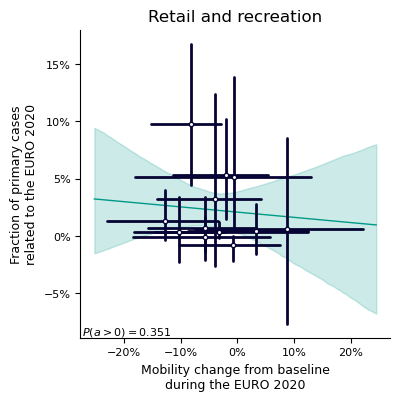

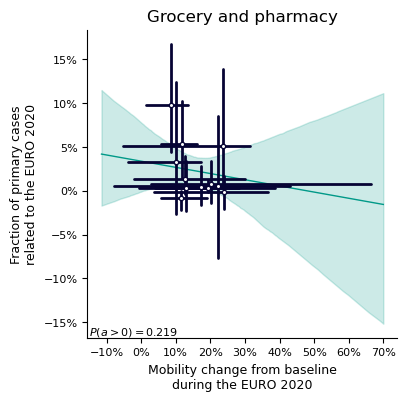

<ipython-input-14-65db577a45f7>:17: UserWarning: Attempting to set identical left == right == 214.01375 results in singular transformations; automatically expanding.
  ax.set_xlim(ax.get_xlim()[1])


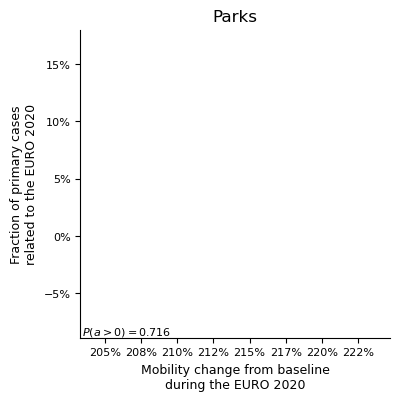

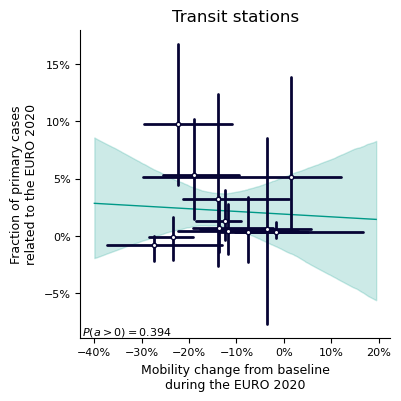

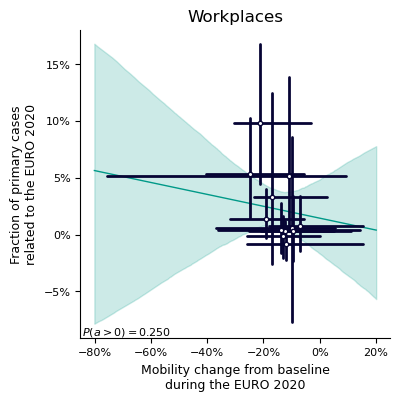

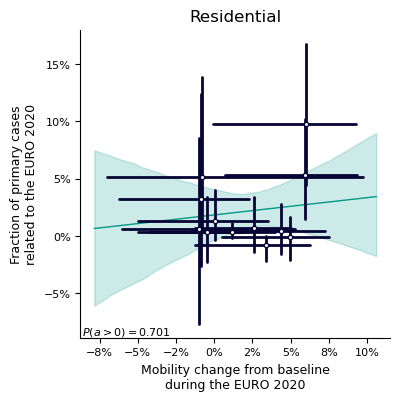

In [14]:
for measure in measures:
    fig,ax = plt.subplots(1,1,figsize=(4,4))

    if measure == "parks_percent_change_from_baseline":
        inverse_pval = True
    else:
        inverse_pval = False

    plot_corr(ax, meanMobilityEuro2020[measure], primary_frac, ci_axis_y=0, ci_axis_x=0,inverse_pvalue=inverse_pval,linearRegression=True)

    ax.set_xlabel("Mobility change from baseline\nduring the EURO 2020")
    ax.set_ylabel("Fraction of primary cases\nrelated to the EURO 2020")
    ax.set_title(measure2title[measure])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(100,0))
    if measure == "parks_percent_change_from_baseline":
        ax.set_xlim(ax.get_xlim()[1])

    plt.show()
    fig.savefig(f"../figures/correlation_Mobility_{measure}.pdf", **save_kwargs)
    fig.savefig(f"../figures/correlation_Mobility_{measure}.png", **save_kwargs)
    plt.close(fig=fig)

## Correlation between Reproduction number pre EURO2020 and effect size

Correlation plot reproduction number pre EURO2020 as inferred from our model and effect size.

In [15]:
reproNumberPreEURO2020 = []
reproNumberPostEuro2020 = []
for i, country in enumerate(countries):
    i_begin = (begin - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_begin-14:i_begin].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPreEURO2020.append(R)

    i_end = (end - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_end-14:i_end].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPostEuro2020.append(R)


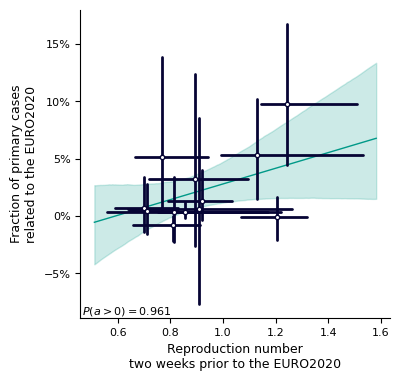

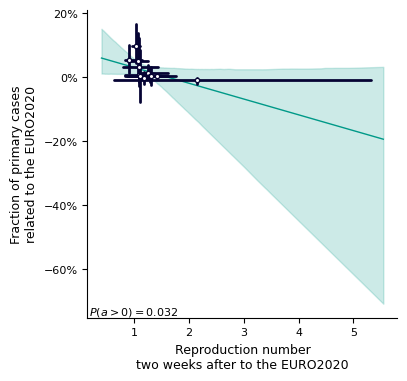

In [16]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, reproNumberPreEURO2020, primary_frac, ci_axis_y=0, ci_axis_x=0, linearRegression=True)
ax.set_xlabel("Reproduction number\ntwo weeks prior to the EURO2020")
ax.set_ylabel("Fraction of primary cases\nrelated to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_ReproNum_preEURO2020.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_ReproNum_preEURO2020.png", **save_kwargs)
plt.close(fig=fig)


fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_corr(ax, reproNumberPostEuro2020, primary_frac, ci_axis_y=0, ci_axis_x=0,linearRegression=True)
ax.set_xlabel("Reproduction number\ntwo weeks after to the EURO2020")
ax.set_ylabel("Fraction of primary cases\nrelated to the EURO2020")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))
plt.show()
fig.savefig(f"../figures/correlation_ReproNum_postEURO2020.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_ReproNum_postEURO2020.png", **save_kwargs)
plt.close(fig=fig)


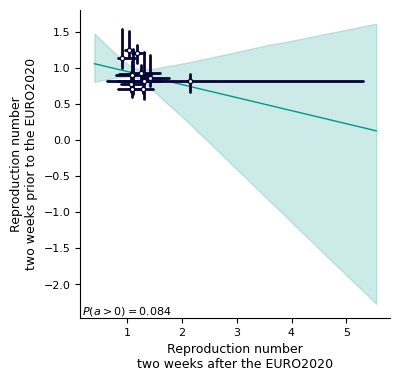

In [17]:
fig,ax= plt.subplots(1,1,figsize=(4,4))
plot_corr(ax,reproNumberPostEuro2020, reproNumberPreEURO2020,ci_axis_y=0, ci_axis_x=0,linearRegression=True)
ax.set_ylabel("Reproduction number\ntwo weeks prior to the EURO2020")
ax.set_xlabel("Reproduction number\ntwo weeks after the EURO2020")
plt.show()

## Correlation between incidence pre EURO2020 and effect size

In [197]:
jhu = cov19dat.JHU(True)


incedencePreEuro2020 = []
incedencePreEuro2020STD = []
incedencePreEuro2020SUM = []
for i, country in enumerate(countries):
    temp = pd.DataFrame()
    temp_m = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "male",
        "total",
    ]
    temp_f = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "female",
        "total",
    ]

    # Reshape to date, gender and male at the front
    t =  np.stack((temp_m.to_numpy(), temp_f.to_numpy()), axis=1)
    incidence = t.sum(axis=(1,2)) / dls[i].population.sum()*1e6
    incedencePreEuro2020SUM.append(t.sum(axis=(0,1,2)) / dls[i].population.sum()*1e6)
    incedencePreEuro2020.append(incidence.mean())
    incedencePreEuro2020STD.append(incidence.std())
    

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [19]:
incidenceRelatedToEuro2020 = []
for i, country in enumerate(countries):
    temp = infections_primary[i]+infections_secondary[i]
    incidenceRelatedToEuro2020.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

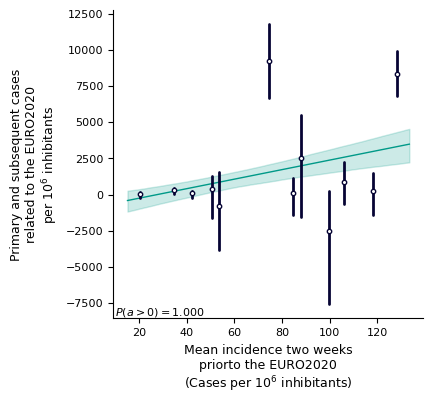

In [20]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

plot_corr(ax,incedencePreEuro2020,incidenceRelatedToEuro2020,ci_axis_y=0,linearRegression=True)
ax.set_ylabel("Primary and subsequent cases\nrelated to the EURO2020\nper $10^6$ inhibitants")
ax.set_xlabel("Mean incidence two weeks\npriorto the EURO2020\n(Cases per $10^6$ inhibitants)")
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(100,0))

plt.show()
fig.savefig(f"../figures/correlation_incidence.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_incidence.png", **save_kwargs)
plt.close(fig=fig)

## Google trends

In [21]:
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
from datetime import datetime, timedelta
import time

def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [22]:
# Baseline
begin_trends = begin - timedelta(days=10)
end_trends = end + timedelta(days=30*5)
googleTrends = []

country2keyword = {
    "England": "football",
    "Scotland": "football",
    "Germany": "fußball",
    "France": "football",
    "Spain": "futbol",
    "Slovakia": "football",
    "Portugal": "futebol",
    "Netherlands": "voetbal",
    "Italy": "football",
    "Czechia": "fotbal",
    "Belgium": "voetbal",
    "Austria": "fußball"
}


country2location = {
    "England": "en-GB",
    "Scotland": "en-GB",
    "Germany": "de-DE",
    "France": "fr-FR",
    "Spain": "es-ES",
    "Slovakia": "sk-SK",
    "Portugal": "pt-PT",
    "Netherlands": "nl-NL",
    "Italy": "it-IT",
    "Czechia": "cs-CZ",
    "Belgium": "nl-BE",
    "Austria": "de-AT"
}

country2timezone = {
    "England": 0,
    "Scotland": 0,
    "Germany": 60,
    "France": 60,
    "Spain": 60,
    "Slovakia": 60,
    "Portugal": 60,
    "Netherlands": 60,
    "Italy": 60,
    "Czechia": 60,
    "Belgium": 60,
    "Austria": 60
}


for i, country in enumerate(countries):



    pytrend = TrendReq(hl=country2location[country])
    keyword = country2keyword[country]
    geo = dls[i].countries_iso2[0]
    cat=1077 # Sport news
    gprop=''
    tz = country2timezone[country]
    dailydata = get_daily_trend(
        pytrend,
        keyword,
        begin_trends.strftime("%Y-%m-%d"),
        end_trends.strftime("%Y-%m-%d"),
        geo=geo,
        cat=cat,
        gprop=gprop,
        tz=tz,
        overlap=30,
    )
    googleTrends.append(dailydata)

    fig,ax= plt.subplots(figsize=(10,5))
    ax.plot(dailydata.index, dailydata[keyword])
    ax.set_title(country)

    


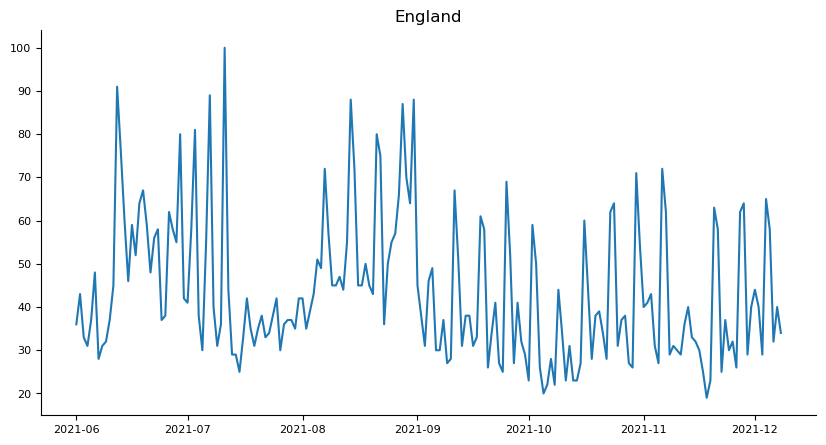

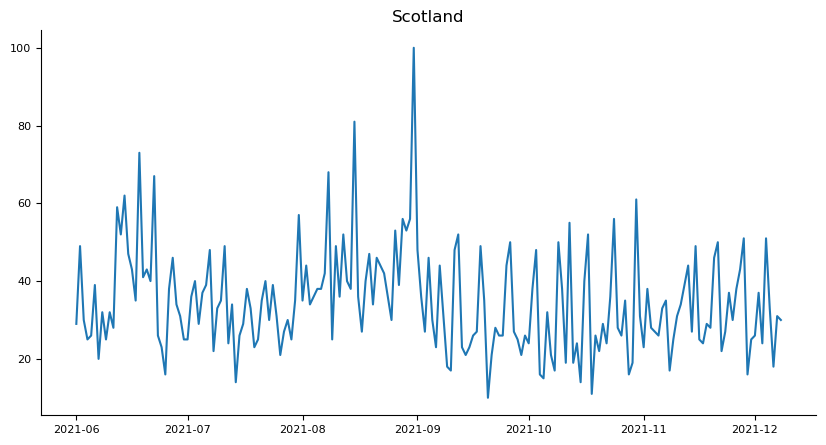

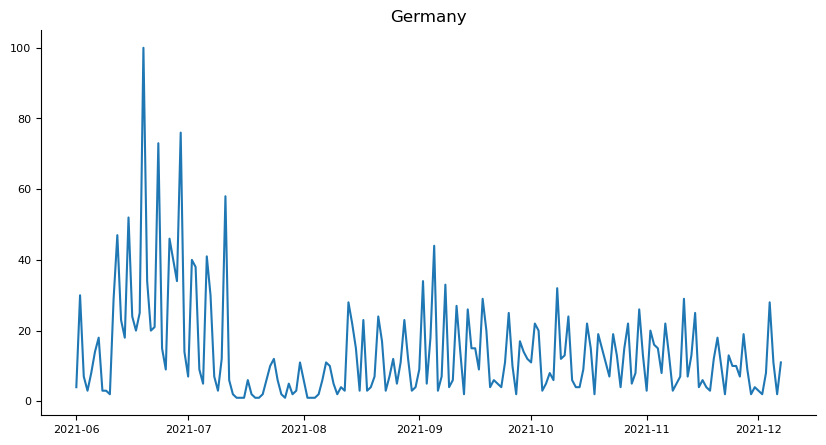

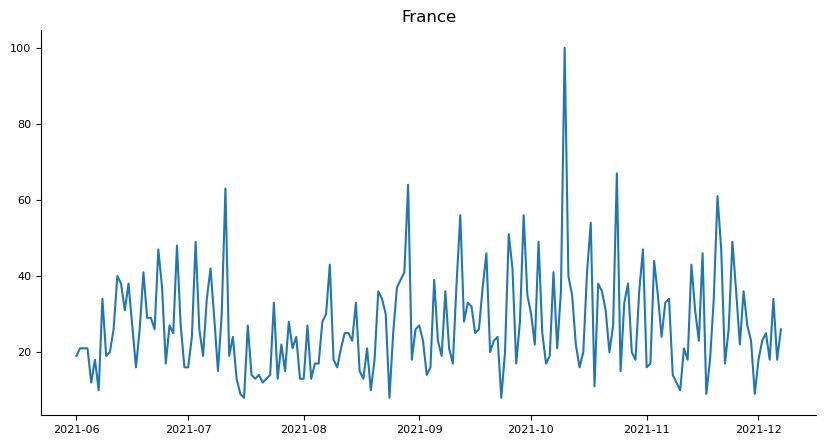

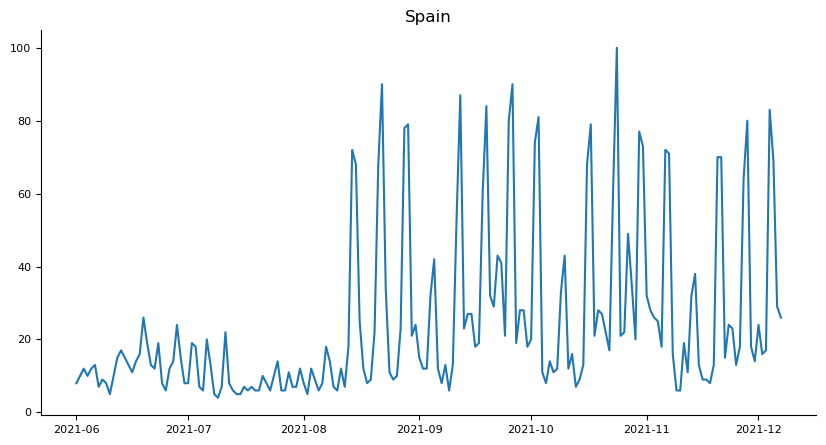

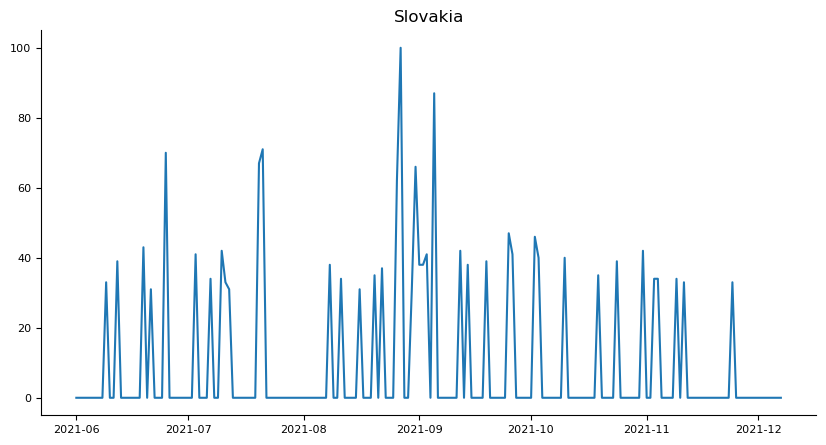

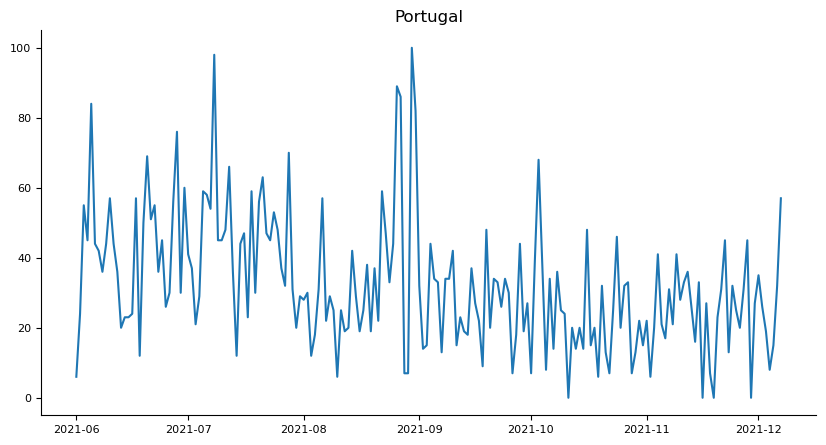

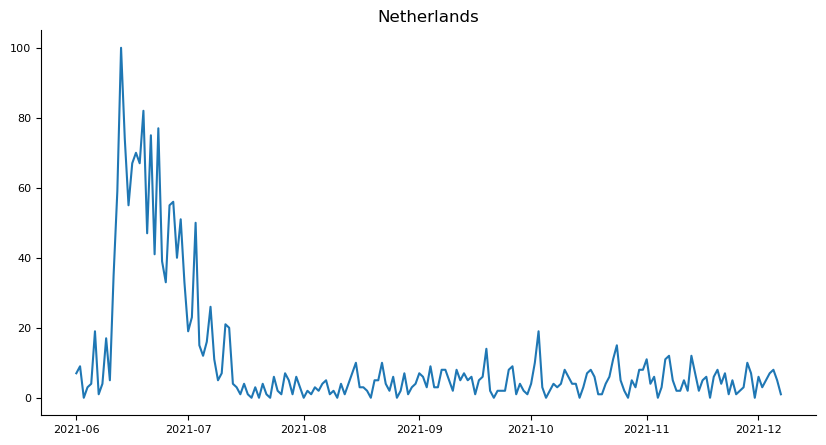

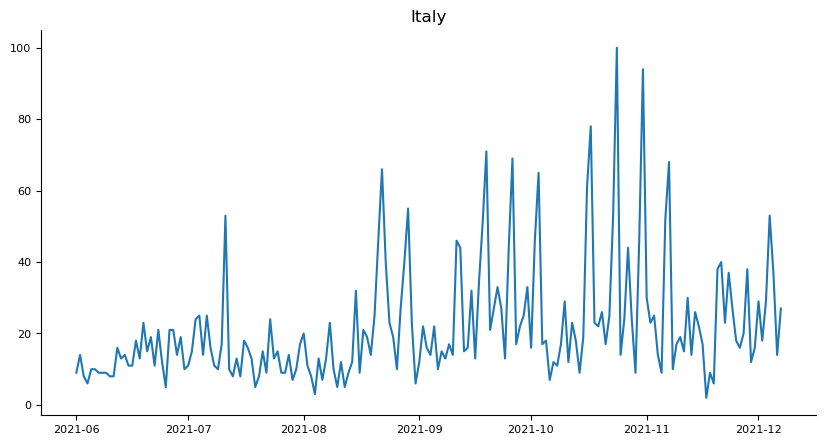

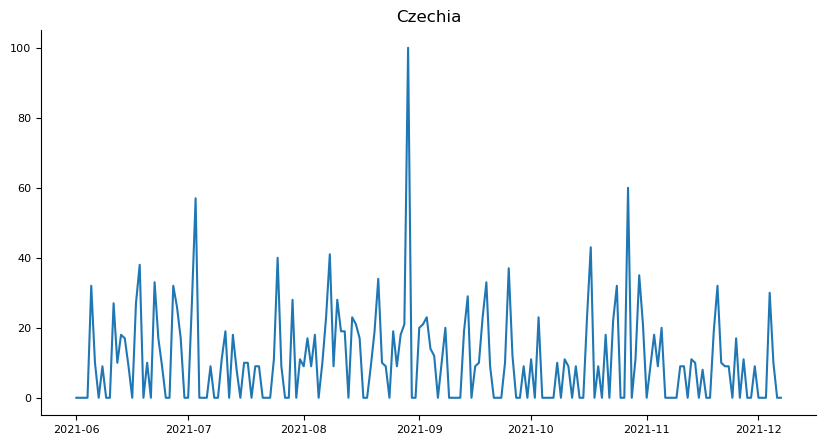

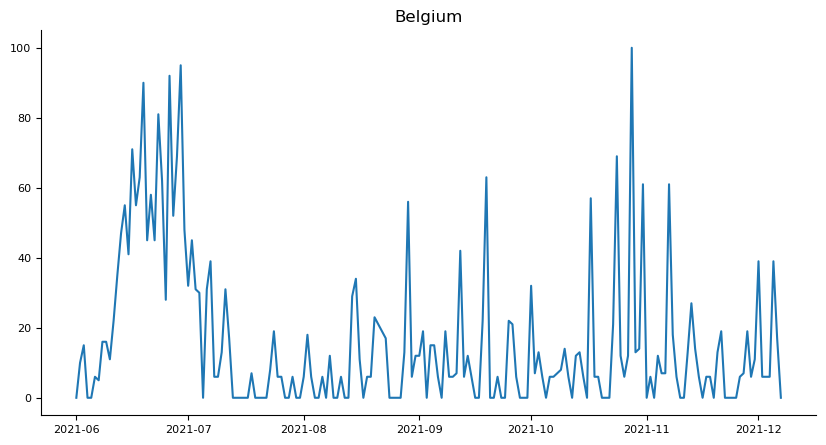

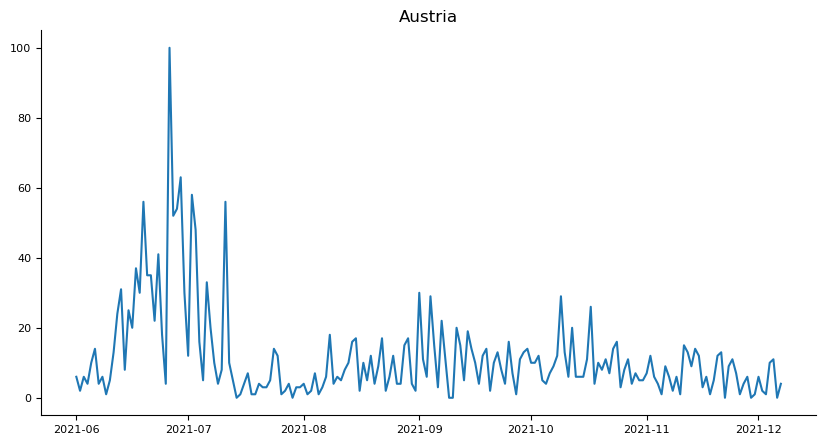

In [23]:
plt.show()

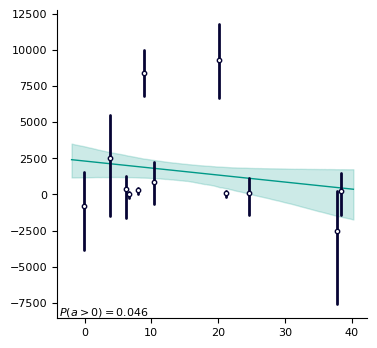

In [24]:
# Calculate increase in trend during the EURO2020
increaseInGoogleTrend = []
increaseInGoogleTrendSTD = []
for i, country in enumerate(countries):
    trends = googleTrends[i]
    trends = trends[trends.columns[0]]
    
    # Increase in percentage
    increase = (trends[begin:end].mean() - trends[:begin].mean())
    std = (trends[begin:end].std() - trends[:begin].std())

    increaseInGoogleTrend.append(increase)
    increaseInGoogleTrendSTD.append(std)
fig,ax= plt.subplots(figsize=(4,4))
plot_corr(ax,increaseInGoogleTrend, primary_and_subsequent_inci,ci_axis_y=0,linearRegression=True)
plt.show()

## Overview

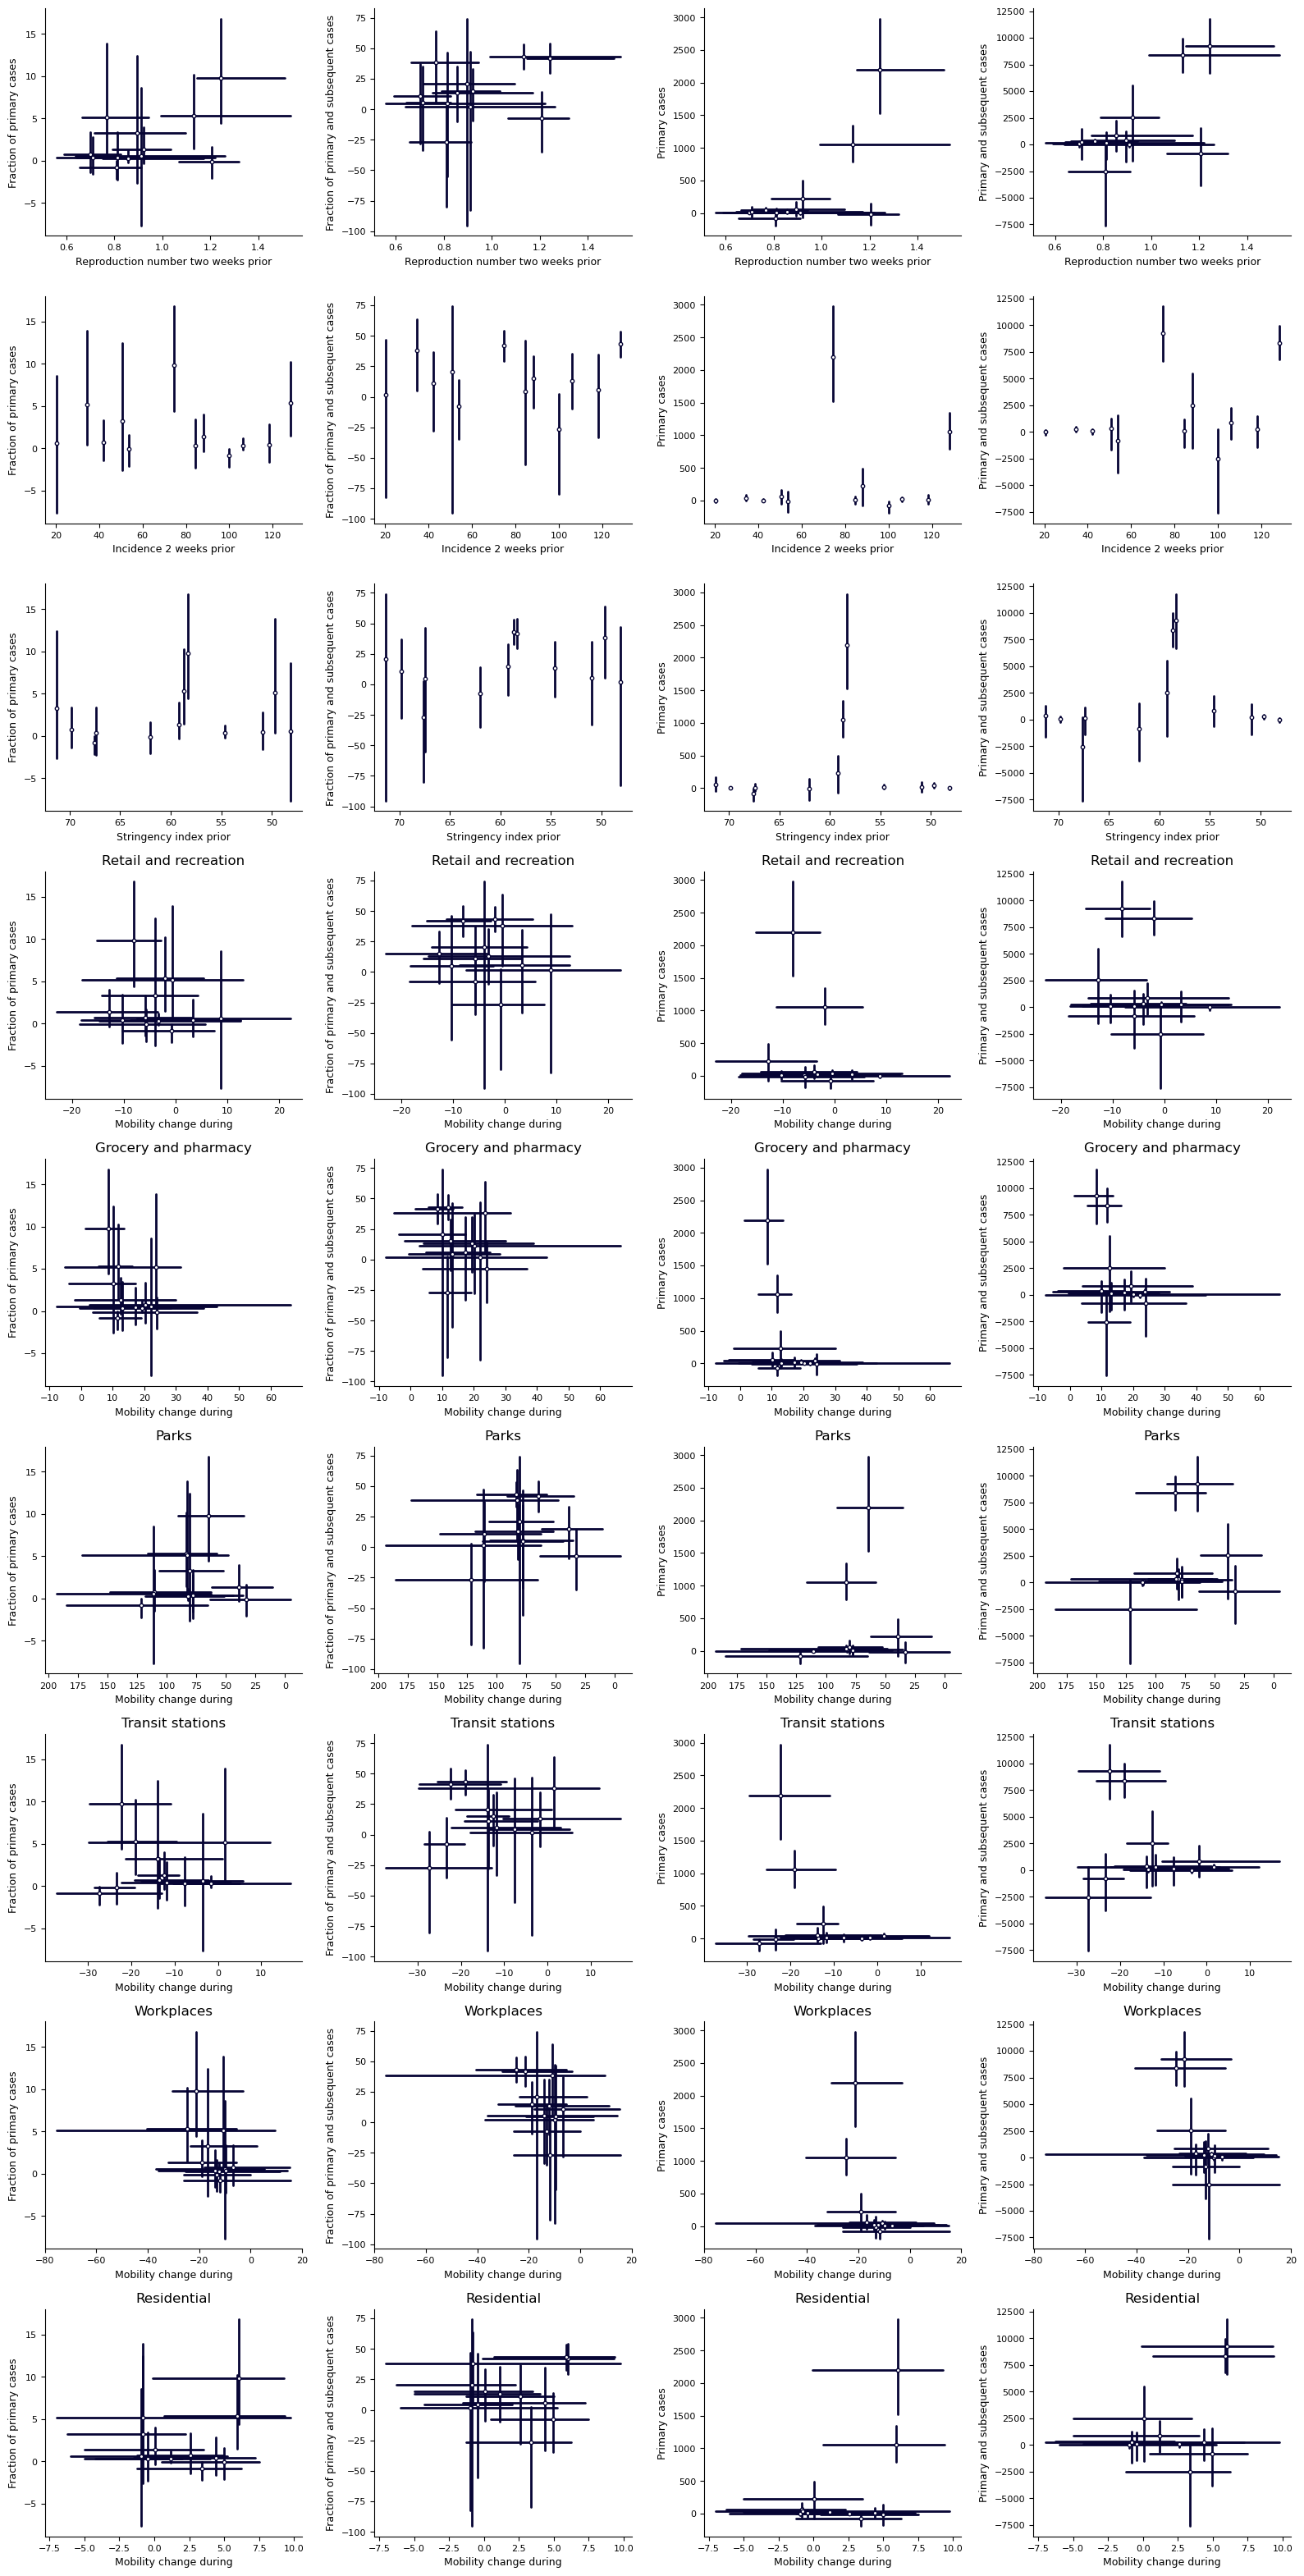

In [140]:
## Big overview plot
# - reproNumberPreEURO2020 vs primary cases | primary & subsequent cases | primary fraction | primary & subsequent fraction

columns = [primary_frac, primary_and_subsequent_frac, primary_inci, primary_and_subsequent_inci]
col_labels = ["Fraction of primary cases", "Fraction of primary and subsequent cases", "Primary cases", "Primary and subsequent cases"]
rows = [reproNumberPreEURO2020, incedencePreEuro2020, meanStringencyPreEuro2020]
row_labels = ["Reproduction number two weeks prior", "Incidence 2 weeks prior", "Stringency index prior"]
# Add mobility
for measure in measures:
    rows.append(meanMobilityEuro2020[measure])
    row_labels.append("Mobility change during")

fig, axes = plt.subplots(len(rows),len(columns),figsize=(4*len(columns),3.5*len(rows)))

for j, r in enumerate(rows):
    for i, c in enumerate(columns):
        if j ==1:
            plot_corr(axes[j,i], r, c, ci_axis_y=0)
        elif j == 2:
            plot_corr(axes[j,i], r, c, ci_axis_y=0, inverse_pvalue=True)
            axes[j,i].set_xlim(axes[j,i].get_xlim()[1],axes[j,i].get_xlim()[0])
        elif (j > 2) and (measures[j-3] == "parks_percent_change_from_baseline"):
            plot_corr(axes[j,i], r, c, ci_axis_y=0, ci_axis_x=0,inverse_pvalue=True)
            axes[j,i].set_xlim(axes[j,i].get_xlim()[1],axes[j,i].get_xlim()[0])
        else:
            plot_corr(axes[j,i], r, c, ci_axis_y=0, ci_axis_x=0,)

        axes[j,i].set_ylabel(col_labels[i])
        axes[j,i].set_xlabel(row_labels[j])

        # Set title for mobility plots
        if j > 2:
            axes[j,i].set_title(measure2title[measures[j-3]])



plt.tight_layout()
plt.show()
fig.savefig(f"../figures/correlation_overview.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation_overview.png", **save_kwargs)
plt.close(fig=fig)


## Data num Games played

In [158]:
import pymc3 as pm
table_3 = []

df = pd.read_csv("../../data/em_game_data.csv",header=2)
df = df[~df["id"].str.contains("a")] # Filter extra games we added for validation these are suffixed with a


country2location = {
    "GB-ENG":"London",
    "IT":"Rome",
    "AZ":"Baku",
    "DE":"Munich",
    "RU":"Saint Petersburg",
    "HU":"Budapest",
    "ES":"Seville",
    "RO":"Bucharest",
    "NL":"Amsterdam",
    "GB-SCT":"Glasgow",
    "DK":"Copenhagen"
}

for i, country in enumerate(countries):
    iso2 = dls[i].countries_iso2[0]
    gamesByTeam = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2)] 
    
    
    if iso2 in country2location:
        location = country2location[iso2]
        gamesHosted = df[df[' location'].str.contains(location)]
    else:
        gamesHosted = np.zeros((0,8))
    
    row = []
    row.append(gamesByTeam.shape[0])
    row.append(gamesHosted.shape[0])
    
    table_3.append(row)
nGamesHostedPlusPlayed = np.array(table_3).sum(axis=1)

In [167]:
df

,id,date,phase,team1,team2,goals1,goals2,location
0,000,2021-06-11,GS,TR,IT,0,3,Rome
1,001,2021-06-12,GS,GB-WLS,CH,1,1,Baku
2,002,2021-06-12,GS,DK,FI,0,1,Copenhagen
3,003,2021-06-12,GS,BE,RU,3,0,Saint Petersburg
4,004,2021-06-13,GS,GB-ENG,HR,1,0,London
5,005,2021-06-13,GS,AT,MK,3,1,Bucharest
6,006,2021-06-13,GS,NL,UA,3,2,Amsterdam
7,007,2021-06-14,GS,GB-SCT,CZ,0,2,Glasgow
8,008,2021-06-14,GS,PL,SK,1,2,Saint Petersburg
9,009,2021-06-14,GS,ES,SE,0,0,Seville


## Pairwise correlation with pymc3

In [199]:

Y = []
Y_err = []
Y_frac = []
Y_frac_err = []
X = []
X_err = []

for i, country in enumerate(countries):
    X_c = []
    X_err_c = []


    Y.append(primary_and_subsequent_inci[i].mean())
    Y_err.append(primary_and_subsequent_inci[i].std())
    
    Y_frac.append(primary_frac[i].mean())
    Y_frac_err.append(primary_frac[i].std())

    x1 = reproNumberPreEURO2020[i].mean()
    x1_err = reproNumberPreEURO2020[i].std()
    X_c.append(x1)
    X_err_c.append(x1_err)

    x2 = incedencePreEuro2020SUM[i]
    x2_err = incedencePreEuro2020STD[i]
    X_c.append(x2)
    X_err_c.append(x2_err)

    x3 = meanStringencyPreEuro2020[i]
    x3_err = stdStringencyPreEuro2020[i]/np.sqrt(len(meanMobilityEuro2020[measure][i]))
    X_c.append(x3)
    X_err_c.append(x3_err)
    
    # Get mobility
    for measure in measures:
        X_c.append(meanMobilityEuro2020[measure][i].mean())
        X_err_c.append(meanMobilityEuro2020[measure][i].std()/np.sqrt(len(meanMobilityEuro2020[measure][i])))

    X.append(X_c)
    X_err.append(X_err_c)

    #print(Y[i]-Y_err[i], Y[i]+Y_err[i])
    #print(np.percentile(primary_and_subsequent_inci[i],[2.5,97.5]))

# Has now shape country, categorie
X = np.array(X)
X_err = np.array(X_err)

# Has now shape country
Y = np.array(Y)
Y_err = np.array(Y_err)

n_countries = X.shape[0]

In [196]:
incedencePreEuro2020SUM

1858.6359139128522

In [207]:
def reduce_samples(curr_list):
    number_of_samples = 2000
    for i, array in enumerate(curr_list):
        array = array[...,np.random.choice(array.shape[-1], number_of_samples, replace = False)]
        curr_list[i] = array
    return np.array(curr_list)

primary_frac_redu = reduce_samples(primary_frac)
primary_and_subsequent_inci_redu = reduce_samples(primary_and_subsequent_inci)

def get_model(X,X_err,Y=Y):
    with pm.Model() as model:
        # Priors Y
        y_data = pm.Data("Y", Y) #

        # Prior X
        x_data = pm.Data("X",X)
        x_data_err = pm.Data("X_err",X_err)
        error = pm.Normal("error", mu=0, sd=1, shape=(n_countries))*x_data_err # Xerror

        # Prior linear fit i.e. no effect 
        tau = pm.HalfCauchy("tau", beta=10_000)
        beta = pm.Normal('beta', mu=0, sd=100_000)
        intercept = pm.Normal('intercept', mu=0, sd=10_000)

        # Country shape
        mu = intercept+(x_data+error)*beta

        deviation = pm.Normal("deviation", mu=0, sigma=1, shape=(n_countries))
        country_effect = deviation*tau + mu
        country_effect = pm.Deterministic("country_effect", country_effect)

        sigma_obs = pm.HalfCauchy("sigma", beta=10000, shape=(n_countries))

        pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=y_data)
    return model



In [179]:
modelNGames = get_model(nGamesHostedPlusPlayed, np.zeros(12),Y=primary_frac_redu)
traceNGames = pm.sample(300, tune=500, cores=4, target_accept=0.9,return_inferencedata=True,model=modelNGames)

Only 300 samples in chain.
WARNING  [pymc3] Only 300 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, intercept, beta, tau, error]
INFO     [pymc3] NUTS: [sigma, deviation, intercept, beta, tau, error]


Sampling 4 chains for 500 tune and 300 draw iterations (2_000 + 1_200 draws total) took 647 seconds.
INFO     [pymc3] Sampling 4 chains for 500 tune and 300 draw iterations (2_000 + 1_200 draws total) took 647 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
WARNING  [pymc3] The rh

In [ ]:
modelReproPreEURO2020 = get_model(X[:,0],X_err[:,0],Y=primary_and_subsequent_inci_redu)
modelIncidencePreEURO2020 = get_model(X[:,1],np.zeros(12),Y=primary_and_subsequent_inci_redu)
modelMobilityParks = get_model(X[:,3],X_err[:,3],Y=primary_frac_redu) #Retail and recreation
modelNGames = get_model(nGamesHostedPlusPlayed, np.zeros(12),Y=primary_frac_redu)

traceIncidencePreEURO2020 = pm.sample(1000, tune=1000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelIncidencePreEURO2020)
traceReproPreEURO2020 = pm.sample(1000, tune=1000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelReproPreEURO2020)
traceMobilityParks = pm.sample(1000, tune=1000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityParks)
traceNGames = pm.sample(1000, tune=1000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelNGames)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, intercept, beta, tau, error]
INFO     [pymc3] NUTS: [sigma, deviation, intercept, beta, tau, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1925 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1925 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increa

In [164]:

# Simple pairwise correlation
def get_model(X,X_err,Y=Y,Y_err=Y_err):
    with pm.Model() as model:
        # Priors Y
        y_data = pm.Data("Y", Y) #
        y_data_err = pm.Data("Y_err",Y_err)
        sigma = pm.HalfCauchy("sigma", beta=3)

        # Prior X
        x_data = pm.Data("X",X)
        x_data_err = pm.Data("X_err",X_err)
        error = pm.Normal("error", mu=0, sd=1, shape=(n_countries))*x_data_err # Xerror

        # Prior linear fit i.e. no effect 
        beta = pm.Normal('beta', mu=0, sd=100000)
        intercept = pm.Normal('intercept', mu=0, sd=10000)

        # Country shape
        mu = intercept+(x_data+error)*beta

        likelihood = pm.Normal('likelihood', mu=mu, sd=y_data_err+sigma, observed=y_data)
    return model

# Construct models
modelReproPreEURO2020 = get_model(X[:,0],X_err[:,0])
modelIncidencePreEURO2020 = get_model(X[:,1],X_err[:,1])
modelMobilityParks = get_model(X[:,3],X_err[:,3],Y=Y_frac,Y_err=Y_frac_err) #Retail and recreation
modelNGames = get_model(nGamesHostedPlusPlayed, np.zeros(12),Y=Y_frac,Y_err=Y_frac_err)

# Inference
#traceIncidencePreEURO2020 = pm.sample(6000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelIncidencePreEURO2020)
#traceReproPreEURO2020 = pm.sample(6000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelReproPreEURO2020)
traceMobilityParks = pm.sample(6000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityParks)
traceNGames = pm.sample(6000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelNGames)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, error, sigma]
INFO     [pymc3] NUTS: [intercept, beta, error, sigma]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 30 seconds.
INFO     [pymc3] Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 30 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
IN

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 35 seconds.
INFO     [pymc3] Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 35 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


In [187]:
from covid19_soccer.plot.utils import get_flag
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_linear_corr(ax, trace, colors):
    """ Simple correlation plot using a pymc3 trace
    """

    # Get datapoints
    Y = np.array(trace.constant_data["Y"])
    if Y.ndim > 1:
        Y = np.median(Y,axis=1)
    if "Y_err" in trace.constant_data:
        Y_err = np.array(trace.constant_data["Y_err"])
    else:
        Y_err = np.median(trace.posterior["sigma"].values,axis=(0,1))
    X = np.array(trace.constant_data["X"])
    X_err = np.array(trace.constant_data["X_err"])

    # Plot data with error
    lines = ax.hlines(
        y=Y,
        xmin=X+X_err,
        xmax=X-X_err,
        lw=2,
        zorder=9,
        color=colors,
    )
    lines.set_capstyle("round")
    lines = ax.vlines(
        x=X,
        ymin=Y+Y_err,
        ymax=Y-Y_err,
        lw=2,
        zorder=9,
        color=colors,
    )
    lines.set_capstyle("round")
    
    ax.scatter(
        x=X,
        y=Y,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor=colors,
    )

    # Plot fit from trace
    x_range = np.arange(ax.get_xlim()[0],ax.get_xlim()[1],0.01)

    beta = np.array(trace.posterior["beta"][:,:])
    beta = beta.reshape(beta.shape[0]*beta.shape[1])

    inter = np.array(trace.posterior["intercept"])
    inter = inter.reshape(inter.shape[0]*inter.shape[1])

    y = inter[np.newaxis,...]+x_range[:,np.newaxis]@beta[np.newaxis,...]

    ax.plot(x_range,y.mean(axis=1),color="tab:gray",lw=1)
    p = np.percentile(y,[0.25,97.5],axis=1)
    ax.fill_between(x_range,p[0],p[1],color="tab:gray",alpha=0.2,zorder=-4)
    
    return ax


from covid19_soccer.plot.other import HandlerPatchImage,PatchImage,MulticolorPatchHandler,MulticolorPatch
from matplotlib.patches import Patch, Rectangle
def legend(ax,colors,loc="center"):
    # Legend
    image_urls = []
    iso2 = []
    for i, dl in enumerate(dls):
        image_urls.append(get_flag(dl.countries_iso2[0].lower(),"/tmp/"))
        iso2.append(dl.countries_iso2[0].replace("GB-", ""))
        
        
        
    lines = []
    for i,color in enumerate(colors):
        lines.append(MulticolorPatch(colors=[color]))
    ax.legend(
        lines,
        iso2,
        loc=loc,
        handler_map={MulticolorPatch:MulticolorPatchHandler()},
        fontsize=6,
    )



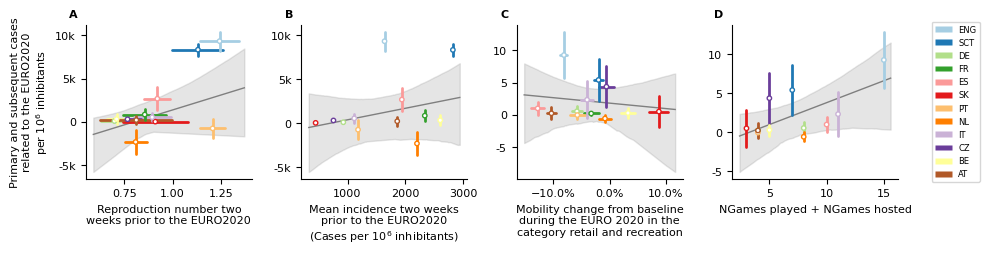

In [209]:
# Create plot
from covid19_soccer.plot.utils import k_formatter
from matplotlib.ticker import PercentFormatter
import string
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

fig,axes=plt.subplots(1,5,figsize=(10,2.7),gridspec_kw={"width_ratios":[1,1,1,1,0.1]})

# Model fits
plot_linear_corr(axes[0],traceReproPreEURO2020,colors)
plot_linear_corr(axes[1],traceIncidencePreEURO2020,colors)
plot_linear_corr(axes[2],traceMobilityParks,colors)
plot_linear_corr(axes[3],traceNGames,colors)

# Format x axis
axes[0].set_xlabel("Reproduction number two\nweeks prior to the EURO2020")
axes[1].set_xlabel("Mean incidence two weeks\nprior to the EURO2020\n(Cases per $10^6$ inhibitants)")
#axes[2].set_xlim(axes[2].get_xlim()[::-1])
axes[2].set_xlabel("Mobility change from baseline\nduring the EURO 2020 in the\ncategory retail and recreation")
axes[3].set_xlabel("NGames played + NGames hosted")
axes[2].xaxis.set_major_formatter(PercentFormatter(100)) 
# Format y axis
for i in range(4):
    axes[i].yaxis.set_major_formatter(k_formatter)
axes[0].set_ylabel("Primary and subsequent cases\nrelated to the EURO2020\nper $10^6$ inhibitants")

# Legend
axes[4].get_xaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[4].axis('off')
legend(axes[4],colors)
fig.align_xlabels()

# Axis labels
alphabet_string = list(string.ascii_uppercase)
for i in range(4):
    letter = alphabet_string[i]
    axes[i].text(
        -0.05,
        1.1,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )
plt.tight_layout()
plt.show()
fig.savefig(f"../figures/correlation.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation.png", **save_kwargs)
plt.close(fig=fig)

In [214]:
# Calc p values

pRepro = (traceReproPreEURO2020.posterior["beta"] > 0).sum() / (traceReproPreEURO2020.posterior["beta"].shape[0] * traceReproPreEURO2020.posterior["beta"].shape[1])
pInci = (traceIncidencePreEURO2020.posterior["beta"] > 0).sum() / (traceIncidencePreEURO2020.posterior["beta"].shape[0] * traceIncidencePreEURO2020.posterior["beta"].shape[1])
pMob = (traceMobilityParks.posterior["beta"] < 0).sum() / (traceMobilityParks.posterior["beta"].shape[0] * traceMobilityParks.posterior["beta"].shape[1])
pNGames = (traceNGames.posterior["beta"] > 0).sum() / (traceNGames.posterior["beta"].shape[0] * traceNGames.posterior["beta"].shape[1])

print(pRepro,pInci,pMob,pNGames)

<xarray.DataArray 'beta' ()>
array(0.75) <xarray.DataArray 'beta' ()>
array(0.894) <xarray.DataArray 'beta' ()>
array(0.6935) <xarray.DataArray 'beta' ()>
array(0.9855)


## Multidimensional corr

Check mobility with number of games

In [30]:
import pymc3 as pm
table_3 = []

df = pd.read_csv("../../data/em_game_data.csv",header=2)
df = df[~df["id"].str.contains("a")] # Filter extra games we added for validation these are suffixed with a


country2location = {
    "GB-ENG":"London",
    "IT":"Rome",
    "AZ":"Baku",
    "DE":"Munich",
    "RU":"Saint Petersburg",
    "HU":"Budapest",
    "ES":"Seville",
    "RO":"Bucharest",
    "NL":"Amsterdam",
    "GB-SCT":"Glasgow",
    "DK":"Copenhagen"
}

for i, country in enumerate(np.array(countries)[country_order_primar]):
    c = country_order_primar[i]
    iso2 = dls[c].countries_iso2[0]
    gamesByTeam = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2)] 
    
    
    if iso2 in country2location:
        location = country2location[iso2]
        gamesHosted = df[df[' location'].str.contains(location)]
    else:
        gamesHosted = np.zeros((0,8))
    
    row = []
    row.append(gamesByTeam.shape[0])
    row.append(gamesHosted.shape[0])
    
    table_3.append(row)
nGamesHostedPlusPlayed = np.array(table_3).sum(axis=1)

In [95]:
#X_new = X[:,3] # Retail and recreation
X_new = X[:,6] # Transit
X_new = np.stack([X_new,nGamesHostedPlusPlayed],axis=1)

X_err_new = X_err[:,3]
X_err_new = np.stack([X_err_new,np.zeros(n_countries)],axis=1)

with pm.Model() as model:
    # Priors Y
    y_data = pm.Data("Y", Y) #
    y_data_err = pm.Data("Y_err",Y_err)
    sigma = pm.HalfCauchy("sigma", beta=3)

    # Prior X
    x_data = pm.Data("X",X_new)
    x_data_err = pm.Data("X_err",X_err_new)
    error = pm.Normal("error", mu=0, sd=1, shape=(n_countries,2))*x_data_err # Xerror

    # Prior linear fit i.e. no effect 
    beta = pm.Normal('beta', mu=0, sd=100000,shape=(2))
    intercept = pm.Normal('intercept', mu=0, sd=100000)

    # Country shape
    mu = intercept+(x_data+error)@beta
    pm.Deterministic("mu",mu)
    pm.Deterministic("sd",y_data_err+sigma)

    likelihood = pm.Normal('likelihood', mu=mu, sd=y_data_err+sigma, observed=y_data)
    
    trace_multi = pm.sample(10000, tune=4000, cores=4,return_inferencedata=True,init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 176700
INFO     [pymc3.variational.inference] Convergence achieved at 176700
Interrupted at 176,699 [88%]: Average Loss = 152.49
INFO     [pymc3.variational.inference] Interrupted at 176,699 [88%]: Average Loss = 152.49
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, error, sigma]
INFO     [pymc3] NUTS: [intercept, beta, error, sigma]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 61 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 61 seconds.
There were 3242 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 3242 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5637142102886084, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.5637142102886084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1158 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 1158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1227 divergences after tuning. Increase `target_accept` or 

In [101]:
mu = trace_multi.posterior["mu"]
sd = trace_multi.posterior["sd"]

mu = mu.to_numpy().reshape(mu.shape[0]*mu.shape[1],mu.shape[2])
sd = sd.to_numpy().reshape(sd.shape[0]*sd.shape[1],sd.shape[2])


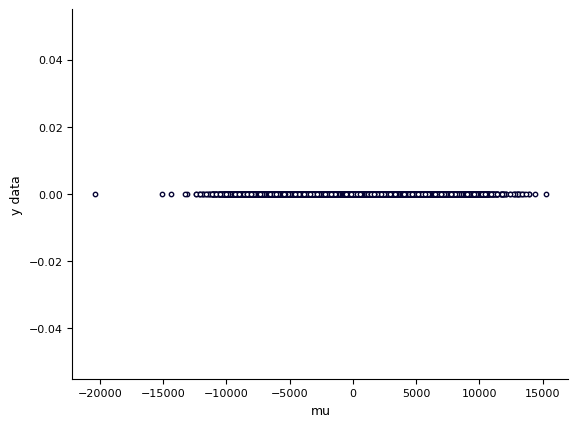

In [134]:
fig,ax= plt.subplots(1,1)
plot_corr(ax,mu-np.stack([Y]*mu.shape[0]),np.zeros(mu.shape))
ax.set_xlabel("mu")
ax.set_ylabel("y data")
plt.show()

In [114]:
np.stack([Y]*mu.shape[0]).shape

(40000, 12)

In [131]:
covid19_soccer.plot.distribution(model,trace_multi,"beta",dist_math=r"\beta")
covid19_soccer.plot.distribution(model,trace_multi,"intercept",dist_math=r"c")

[<AxesSubplot:>]

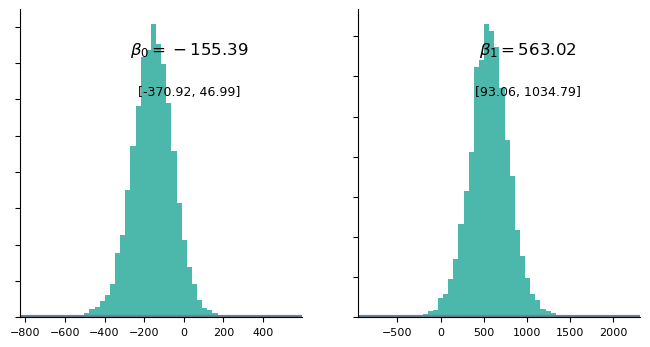

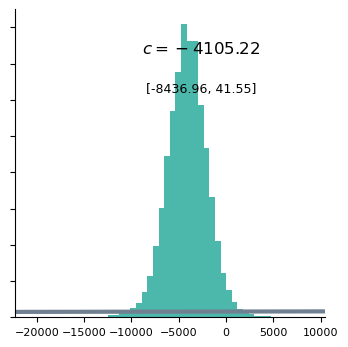

In [132]:
plt.show()

In [121]:
# for creating a responsive plot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_new[:,0], X_new[:,1], Y, marker="o")


x = np.linspace(-10, 5, 1000)
y = np.linspace(4, 5, 1000)
z = -2954+489*x+995*y


ax.plot3D(x, y, z, 'maroon')

ax.set_xlabel('Mobility')
ax.set_ylabel('Games')
ax.set_zlabel('Primary and subsequent cases')
plt.show()

<ipython-input-121-89afaa4b146b>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0, 'Primary and subsequent cases')

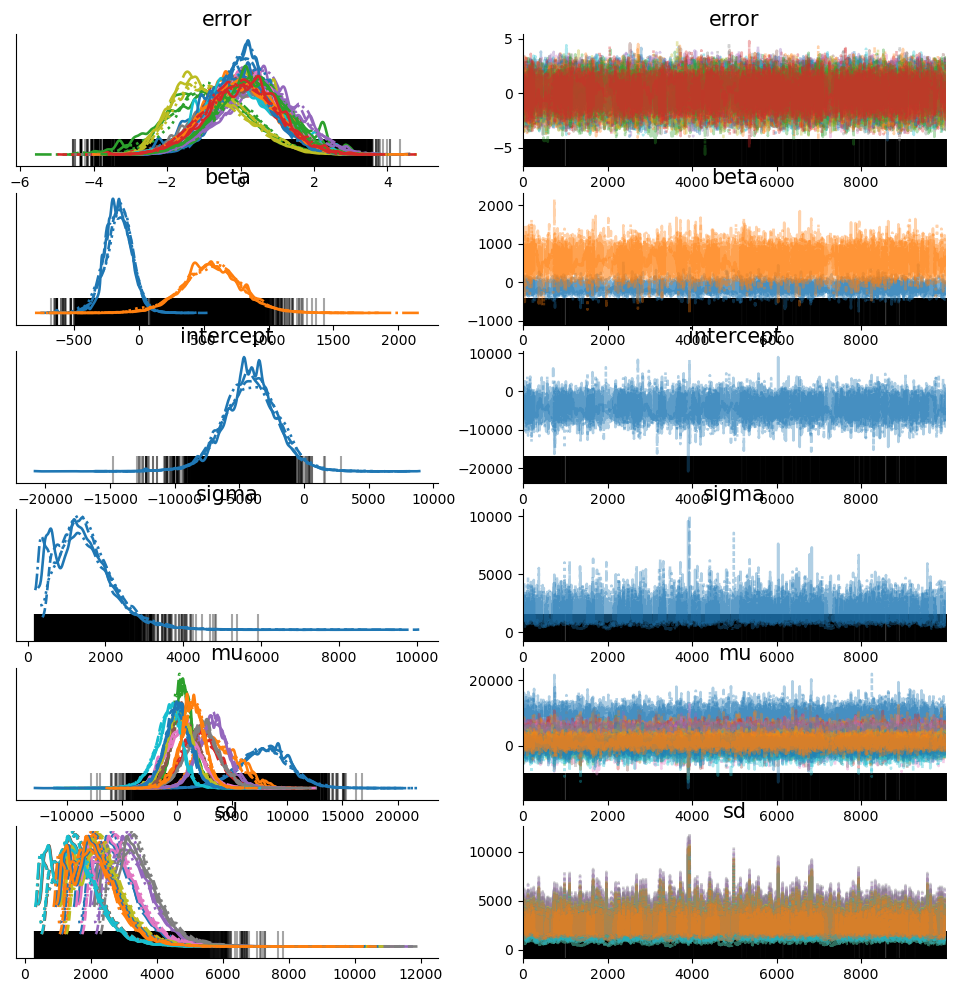

In [133]:
import arviz as az
az.plot_trace(trace_multi)
plt.show()

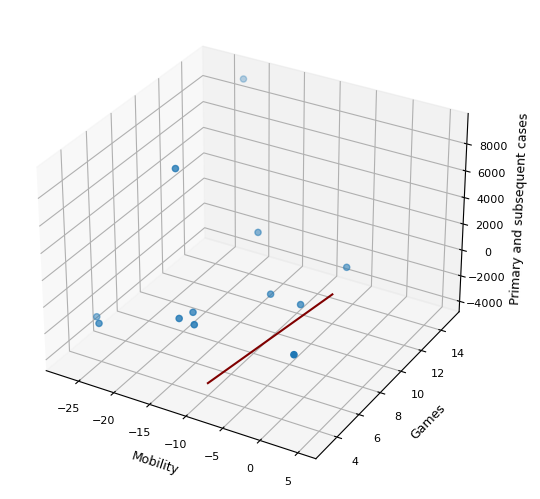